How to create a balanced repair data set?
===

This is a short introduction and example on how to create a balanced repair dataset. Theoretically all results in this notebook are reproducible. However for most parts you need access to internal datasets. 

Repair data contains the following columns:
- ``status``: Explaining the relation between repair_circuit and circuit / specification
- ``assumptions``, ``guarantees``: LTL specification, separated in a list of assumptions and guarantees
- ``repair_circuit``: An aiger circuit, possibly broken, might satisfy the LTL specification and might be equal to the target ``circuit``. Should at least be similar to the target ``circuit`` in some way. To be repaired such that it eventually satisfies the specification.
- ``inputs``, ``outputs``, ``realizable``: additional information about the specification
- ``circuit``: an aiger circuit, which satisfies the specification. Used as target. While called ``circuit`` we mostly refer to it as target ``circuit``, to avoid confusion with ``repair_circuit``
- ``hash`` (optionally but strongly encouraged): A hash, which uniquely identifies the sample (modulo ``repair_circuit`` and target ``circuit``). 
- ``levenshtein_distance`` (optionally): This is the Levenshtein Edit Distance between the repair circuit and the target ``circuit``

A LTL repair dataset is different to normal a  LTL synthesis dataset by the columns ``repair_circuit`` and ``status``, which are co-dependent. The ``repair_circuit`` is supposed to aid the finding of a circuit which satisfies the specification. ``status`` describes the relation between the target ``circuit`` / specification and the ``repair_circuit``. ``status`` can (but not must)be:
 - *Match* meaning the ``repair_circuit`` $=$ ``circuit``
 - *Satisfied* meaning the ``repair_circuit`` $\models$ (``assumptions`` $\rightarrow$ ``guarantees``) 
 - *Changed* meaning the ``repair_circuit`` is an artificially changed version of ``circuit``
 - *Violated* meaning the ``repair_circuit`` $\not\models$ (``assumptions`` $\rightarrow$ ``guarantees``)


A ltl repair dataset is based on a ltl synthesis dataset (e.g. scpa-2). We have two main techniques to construct such datasets, which can also be combined. 
 - We can create a repair dataset by artificially altering the circuit from a LTL synthesis dataset.
 - We base the dataset on the evaluation results of an LTL synthesis model. 

# Artificially alter circuits

Lets first have a look at the artificial method. 

## Exemplary circuit

Lets load and parse an aiger circuit:

In [2]:
from ml2.aiger import parse
circuit_str = "aag 6 5 0 5 1\n2\n4\n6\n8\n10\n0\n12\n26\n0\n0\n12 12 5\ni0 i0\ni1 i1\ni2 i2\ni3 i3\ni4 i4\no0 o0\no1 o1\no2 o2\no3 o3\no4 o4"
circuit = parse(circuit_str)
print(circuit)

2022-06-22 11:57:45.901169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 11:57:45.901197: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


aag 6 5 0 5 1
2
4
6
8
10
0
12
26
0
0
12 12 5
i0 i0
i1 i1
i2 i2
i3 i3
i4 i4
o0 o0
o1 o1
o2 o2
o3 o3
o4 o4


We can now alter the circuit using a few random variables. We first decide on how many changes are performed on the sample. In some cases we delete a whole line, which we uniformly choose, in other cases we uniformly select a position to change. In this position we then choose a new aiger variable we use instead of the old aiger variable. 

The following parameters can be set:
 - for the number of changes we use a normal distribution, where
   - ``max_changes`` defines the maximum number of changes we perform on this circuit. Default 50.
   - ``min_changes`` is the minimal number of changes we perform on this circuit. Default 1.
   - ``range_68_changes`` indirectly defines the $\sigma$ of the random variable. ~68% of all samples should have at most ``range_68_changes`` changes. Default 15.
   - The actual number of changes might be lower, as it counts as multiple changes if we change a position we had already changed. 
- for selecting a new aiger variable at a position, we use the old aiger variable as a the mean of a normal distribution.
  - ``min_var`` defines the new minimal variable that is supported. Default 0.
  - ``max_var`` defines the new maximal variable that is supported. Default 61.
  - ``range_68_var`` indirectly defines the $\sigma$ of the random variable. ~68% of all the new variables should be around the old var with maximal distance of ``range_68_var``. Default 20.
- for ``fraction_delete`` of all changes, we uniformly choose a line to delete. (No inputs or outputs) Default 0.2.

The following plots show the distribution with default values. We exemplary choose 12 as the old aiger variable.

Text(0.5, 1.0, 'Frequency Histogram\nwhich new variable is chosen to replace the exemplary value 12')

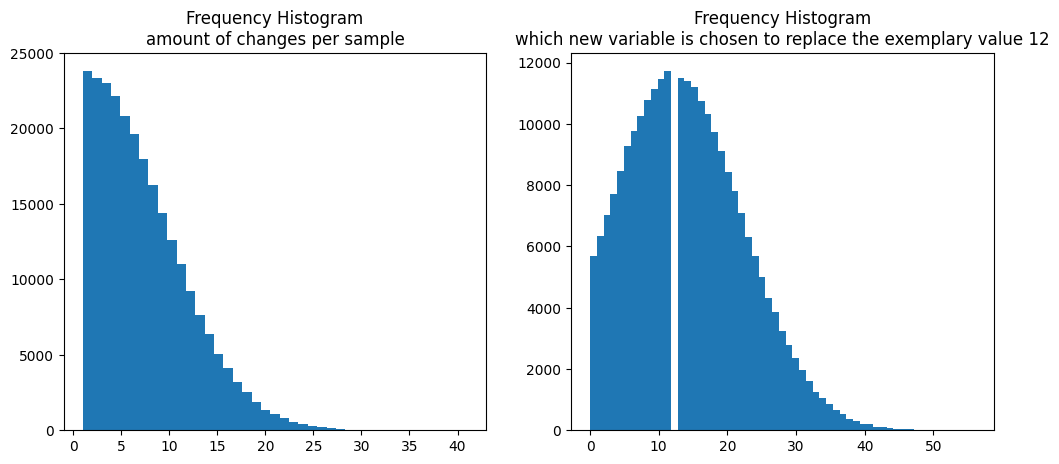

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})


amount = np.stack([circuit.sample_amount_changes() for _ in range(250000)])
new = np.stack([circuit.sample_new_var(12) for _ in range(250000)])

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(amount, bins=amount.max() - amount.min() + 1)
#axs[0].set_title("Frequency Histogram\namount of changes per sample")
axs[1].hist(new, bins=new.max() - new.min() + 1)
#axs[1].set_title("Frequency Histogram\nwhich new variable is chosen to replace the exemplary value 12")



Lets now alter the circuit based on this algorithm and random variables. We omit the symbol table for better readability. Changes also do not affect the header, as the header is not relevant in the training process.

In [3]:
print("before: " + str(circuit)[:-60])
circuit.alter(max_changes=50, min_changes=1, range_68_changes = 15, min_var = 0, max_var = 61, range_68_var = 20, fraction_delete = 0.2)
print("after: " + str(circuit)[:-60])

before: aag 6 5 0 5 1
2
4
6
8
10
0
12
26
0
0
12 12 5
after: aag 6 5 0 5 1
22
9
20
8
13
8
12
26
22
1
12 10 5


## Create Dataset

You can load a dataset interactively and then alter the circuits:

In [4]:
from ml2.ltl.ltl_repair.ltl_repair_data import LTLRepairSplitData

# set calc_stats = False to refrain form calculating statistics when loading (better performance)
# for performance purposes, in this example, we use only 500 samples from each split.
dataset = LTLRepairSplitData.load_from_LTLSynData("scpa-2-repair-test", overwrite=False, load_from="scpa-2", calc_stats=False, samples = 500)
dataset.alter_circuit()
dataset.add_metadata()
print(dataset.pretty_metadata)

INFO:ml2.artifact:Found split_data scpa-2 locally
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Read in metadata
alter circuits: 100%|██████████| 500/500 [00:07<00:00, 66.49it/s] 
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics


{
    "inputs": ['i0', 'i1', 'i2', 'i3', 'i4'],
    "outputs": ['o0', 'o1', 'o2', 'o3', 'o4'],
    "parent_dataset": "scpa-2",
    "test": {
        "changed_fraction": 1.0,
        "distance_all_mean": 10.91,
        "distance_all_median": 9.0,
        "distance_all_std": 8.42,
        "distance_broken_mean": 10.91,
        "distance_broken_median": 9.0,
        "distance_broken_std": 8.42,
        "distance_lower_10_fraction": 0.54,
        "distance_lower_50_fraction": 1.0,
        "match_fraction": 0.0,
        "num_samples": 500,
        "realizable_fraction": 0.55,
        "satisfied_fraction": 0.0,
        "violated_fraction": 0.0
    },
    "test_fraction": 0.3333333333333333,
    "train": {
        "changed_fraction": 1.0,
        "distance_all_mean": 11.53,
        "distance_all_median": 9.0,
        "distance_all_std": 9.37,
        "distance_broken_mean": 11.53,
        "distance_broken_median": 9.0,
        "distance_broken_std": 9.37,
        "distance_lower_10_fraction":

In [5]:
print(dataset["val"])

      status          assumptions           guarantees       repair_circuit          inputs         outputs  realizable              circuit                 hash  levenshtein_distance
0    Changed  (X (G ((! (o0)) ...  (G ((i0) -> (o4)...  aag 9 5 1 5 3\n3...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 9 5 1 5 3\n2...  b6c1a3251946015b...                   36 
1    Changed                       (G (((o4) & (X (...  aag 7 5 1 5 1\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 7 5 1 5 1\n2...  6893e2ccb80ebe6d...                    2 
2    Changed                       (G (((i1) & (X (...  aag 6 5 0 5 1\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 6 5 0 5 1\n2...  b244e392d6015a4e...                    4 
3    Changed                       (G ((! (o4)) | (...  aag 17 5 3 5 9\n...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 17 5 3 5 9\n...  19407228d6b7ac97...                    2 
4    Changed                       (G ((o4) -> (X (...  aag 10 5 1 5 4\n...  i0,

## Creating the dataset in the terminal and batch creation
To transform a LTL synthesis dataset to a LTL repair dataset using these operations, use the following operation in terminal:

    python -m ml2.ltl.ltl_repair.ltl_repair_data alter --name scpa-2-repair-test --from scpa-2

Where ``--name`` is the new name of the dataset and ``--from`` is the ltl dataset chosen as base for the new dataset.
Optionally add the following options:
 - ``--overwrite-base`` whether to download the newest base version from the server 
 - ``--overwrite-new`` whether to overwrite the resulting dataset in case it already exists
 - ``--upload`` whether to upload the resulting dataset to the server
 - ``--splits`` to choose different splits than the default ones
 - ``--max-changes``, ``--min-changes``, ``--range-68-changes``, ``--min-var``, ``--max-var``, ``--range-68-var``, ``--fraction-delete`` as already explained


Alternatively, to create multiple dataset at once, you might consider batch creation: 

    python -m ml2.ltl.ltl_repair.ltl_repair_data sweep --name scpa-repair --mode alter --from scpa-2 --sweep-table ...

You can optionally add the following options
- ``--overwrite-base`` whether to download the newest base version from the server 
- ``--overwrite-new`` whether to overwrite the resulting dataset in case it already exists
- ``--upload`` whether to upload the resulting dataset to the server
- ``--splits`` to choose different splits than the default ones

``--name`` is the the name of the sweep, all experiments of the sweep will be auto-versioned with this name.
 ``--from`` is the ltl dataset chosen as base for the new dataset and ``--sweep-table`` is a pandas dataframe exported as json string, declaring all options.

The sweep table can contain the following optional columns:
 - ``name`` if you want to give the dataset a unique name
 - ``max_changes``, ``min_changes``, ``range_68_changes``, ``min_var``, ``max_var``, ``range_68_var``, ``fraction_delete``. 

Here is an example of a sweep table and how th export the json string:


In [1]:
import pandas as pd
sweep_alter = pd.DataFrame(
    [
        [50, 15, 40, 0.2],
        [50, 15, 20, 0.2],
    ],
    columns=["max_changes", "range_68_changes", "range_68_var", "fraction_delete"],
)
print(sweep_alter.to_string(max_rows=20))
string = sweep_alter.to_json(orient="table", index=False)
print(string)

   max_changes  range_68_changes  range_68_var  fraction_delete
0           50                15            40              0.2
1           50                15            20              0.2
{"schema":{"fields":[{"name":"max_changes","type":"integer"},{"name":"range_68_changes","type":"integer"},{"name":"range_68_var","type":"integer"},{"name":"fraction_delete","type":"number"}],"pandas_version":"0.20.0"},"data":[{"max_changes":50,"range_68_changes":15,"range_68_var":40,"fraction_delete":0.2},{"max_changes":50,"range_68_changes":15,"range_68_var":20,"fraction_delete":0.2}]}


# Using Evaluation Data

Secondly we can use LTL synthesis evaluation results to create a repair dataset.

## Evaluation

First we need to evaluate a ltl synthesis model (in this case ``LTLRepairGenData`` from file ``ltl_repair_data_gen``). By setting ``--data`` to ``generate`` we use the whole dataset (i.e. all samples and all splits) for evaluation. Thus, this takes significant time on a gpu and should be executed only once. For reproducibility you could use the following command:

    python -m ml2.ltl.ltl_repair.ltl_repair_data_gen eval -n repair-data-2 --beam-sizes 1 2 3 4 --data generate -u

Choose your desired beam size for evaluation, though it is recommended to generate all from 1 to 4. With ``-u``, the data is automatically uploaded to the server and can be found in the ``gen`` folder of the model (in this case ``repair-data-2``). Note: If you choose a different model than ``repair-data-2``, you obviously have to train it first. We refer the work of Schnitt et al. (Neural Circuit Synthesis from Specification Patterns).

## Loading Evaluation Data

Using the generated evaluation data, we can load this data into a repair data set:

In [1]:
from ml2.ltl.ltl_repair.ltl_repair_data import LTLRepairSplitData

dataset = LTLRepairSplitData.load_from_LTLRepairGenData("scpa-2-repair-test", load_from_model="repair-data-2", load_from_alpha=[0.5], load_from_beamsize=[1], overwrite=False, calc_stats=False) # remove calc stats false
print(dataset.pretty_metadata)

2022-06-23 10:35:00.703221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 10:35:00.703248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:ml2.artifact:Found experiment repair-data-2 locally
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/repair-data-2/gen/a0.5-bs1/train.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 196700 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/repair-data-2/gen/a0.5-bs1/val.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 24580 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/m

{
    "eval_alpha": 0.5,
    "eval_beam_size": "1",
    "inputs": ["i0", "i1", "i2", "i3", "i4"],
    "outputs": ["o0", "o1", "o2", "o3", "o4"],
    "parent_dataset": "scpa-2",
    "parent_model": "repair-data-2"
}


In [2]:
dataset["val"].plot_lev(filter_range=[1, None], bins=300, x_label = None, dataset_name = dataset.name + "(val)").show()

In [7]:
print(dataset["val"])

          status          assumptions           guarantees       repair_circuit          inputs         outputs  realizable              circuit                 hash  levenshtein_distance
0       Violated                       ((G ((i2) -> (F ...  aag 17 5 2 5 10\...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 18 5 2 5 11\...  a6477a33efaba56f...                   34 
1      Satisfied                       ((G (((o3) & (X ...  aag 5 5 0 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 7 5 1 5 1\n2...  09f21ff72fe9e8d9...                   24 
2       Violated                       ((G ((i0) -> (X ...  aag 9 5 1 5 3\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 11 5 1 5 5\n...  1fbc7bf3ffce8a9d...                   26 
3       Violated  ((G ((i3) -> (F ...  ((G ((((i3) & (i...  aag 6 5 1 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 12 5 1 5 6\n...  eb516b8f1fcddafe...                   65 
4          Match                       (((F (i4)) <-> (...  

However, taking the dataset as is, the dataset is unbalanced and has some structural problems:

## Problems with semantic correctness

As known from the neural LTL synthesis, we have to differ between semantic and syntactic correctness. We call an evaluated sample syntactically correct if the ``repair_circuit`` is equal to the target ``circuit``, hence it is a *Match*. A sample is semantically correct if the ``repair_circuit`` satisfies the specification, hence ``repair_circuit`` and ``circuit`` are in the equivalence class of satisfying circuits for this specification. In other words, the ``repair_circuit`` will be an alternative target for the repair model. This ambiguity is most likely disrupting the training success as it forces the model to learn syntactic correctness while semantic correctness would suffice and is possibly even better as discussed in the work of Schmitt et al.

Training with such semantically correct but syntactically wrong samples would, in the best case, create a misleading training signal for changing / repairing circuits which are already semantically correct. Even for semantically false samples, it is not unlikely that the ``repair_circuit`` is much closer to a different (semantically correct) circuit than to the actual target ``circuit``. We jointly describe these samples as having a misleading target.

To remove the misleading target we may apply two algorithms. 
 1. For semantically correct samples, replace the target with the repair_circuit.
 2. For semantically false samples we search for semantically correct circuits, hence alternative targets, which are closer to the repair_circuit than the original target

To measure how *close* to circuits are, we decided for the Levenshtein Edit Distance.

### Misleading Targets \#1

First we apply the simple algorithm of replacing the target of each semantically correct sample with its repair circuit. Concluding that, each sample with the status *Satisfied* will be *Match*

We normally should choose the training split instead of the validation split, as these changes are only important during training, but for demonstration purpose we use the ``val`` split here.

We can either only calculate the theoretical edit distance, we would have when replacing the target circuit ...

In [8]:
dataset["val"].add_levenshtein(consider_satisfied=False)
print(dataset["val"].data_frame["levenshtein_distance"].mean())
dataset["val"].add_levenshtein(consider_satisfied=True)
print(dataset["val"].data_frame["levenshtein_distance"].mean())

39.75853509664293


treat satisfied as match: 100%|██████████| 24575/24575 [00:32<00:00, 766.34it/s] 

28.519308240081383


... or actually replace the target circuit:

In [9]:
print(dataset["val"])
dataset["val"].treat_satisfied_as_match()
print(dataset["val"])

          status          assumptions           guarantees       repair_circuit          inputs         outputs  realizable              circuit                 hash  levenshtein_distance
0       Violated                       ((G ((i2) -> (F ...  aag 17 5 2 5 10\...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 18 5 2 5 11\...  a6477a33efaba56f...                   34 
1      Satisfied                       ((G (((o3) & (X ...  aag 5 5 0 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 7 5 1 5 1\n2...  09f21ff72fe9e8d9...                    0 
2       Violated                       ((G ((i0) -> (X ...  aag 9 5 1 5 3\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 11 5 1 5 5\n...  1fbc7bf3ffce8a9d...                   26 
3       Violated  ((G ((i3) -> (F ...  ((G ((((i3) & (i...  aag 6 5 1 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 12 5 1 5 6\n...  eb516b8f1fcddafe...                   65 
4          Match                       (((F (i4)) <-> (...  

treat satisfied as match: 100%|██████████| 24575/24575 [00:28<00:00, 861.45it/s] 

         status          assumptions           guarantees       repair_circuit          inputs         outputs  realizable              circuit                 hash  levenshtein_distance
0      Violated                       ((G ((i2) -> (F ...  aag 17 5 2 5 10\...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 18 5 2 5 11\...  a6477a33efaba56f...                   34 
1         Match                       ((G (((o3) & (X ...  aag 5 5 0 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 5 5 0 5 0\n2...  09f21ff72fe9e8d9...                    0 
2      Violated                       ((G ((i0) -> (X ...  aag 9 5 1 5 3\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 11 5 1 5 5\n...  1fbc7bf3ffce8a9d...                   26 
3      Violated  ((G ((i3) -> (F ...  ((G ((((i3) & (i...  aag 6 5 1 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 12 5 1 5 6\n...  eb516b8f1fcddafe...                   65 
4         Match                       (((F (i4)) <-> (...  aag 7 

### Misleading Targets \#2

To find alternative target with a smaller edit distance to the ``repair_circuit`` that the original target, we first have to generate alternative targets. We do this by using the evaluation data from different beams. In fact we combine all results from beam size 1 to beam size 4 (bigger beam sizes would also be possible but take even longer evaluating). We then only keep semantically correct circuits by making semantically correct samples to syntactically correct samples using the same principle described above. We call this the reference dataset. 

Let us load the reference dataset:

In [11]:
dataset_reference = LTLRepairSplitData.load_from_LTLRepairGenData("scpa-2-repair-1", load_from_model="repair-data-2", load_from_alpha=[0.5], load_from_beamsize=[1,2,3,4], overwrite=False, calc_stats=False, is_reference=True, splits=["val"])

len(dataset_reference["val"].data_frame)

INFO:ml2.artifact:Found split_data repair-data-2 locally
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/repair-data-2/gen/a0.5-bs1/val.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 24580 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/repair-data-2/gen/a0.5-bs2/val.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 48809 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/repair-data-2/gen/a0.5-bs3/val.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 72790 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/repair-data-2/gen/a0.5-bs4/val.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 96570 ==============

39164

For each sample in the dataset we like to improve, we search in the reference dataset for all samples having the same specification. If the distance to their target is smaller than to the current one, we use the alternative target instead:

Let $circuit_s$ denote, the circuit of a sample $s$, $lev(a,b)$ the Levenshtein Edit Distance between $a$ and $b$, and $E_s$ the set of all samples with the same specification as $s$, we could find.

$circuit_s := circuit_{s'} \text{ where } lev(circuit_{s'}, repair\_circuit_s) \text{ is minimal and }s' \in E(s) $

As before, we use the ``val`` split instead of the training split.
We first only calculate the distance and secondly also replace the misleading target with a better target.

In [12]:
print(dataset["val"].data_frame["levenshtein_distance"].mean())
dataset["val"].add_levenshtein(consider_minimal=True, dataset_reference= dataset_reference['val'])
print(dataset["val"].data_frame["levenshtein_distance"].mean())

28.519308240081383


treat satisfied as match: 100%|██████████| 24575/24575 [00:24<00:00, 1019.59it/s]
replacing misleading target with minimal distance target: 100%|██████████| 24575/24575 [02:10<00:00, 188.30it/s]

24.333591047812817


In [13]:
print(dataset["val"])
dataset["val"].find_minimal_alternative_target(dataset_reference['val'])
print(dataset["val"])

         status          assumptions           guarantees       repair_circuit          inputs         outputs  realizable              circuit                 hash  levenshtein_distance
0      Violated                       ((G ((i2) -> (F ...  aag 17 5 2 5 10\...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 18 5 2 5 11\...  a6477a33efaba56f...                    9 
1         Match                       ((G (((o3) & (X ...  aag 5 5 0 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 5 5 0 5 0\n2...  09f21ff72fe9e8d9...                    0 
2      Violated                       ((G ((i0) -> (X ...  aag 9 5 1 5 3\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 11 5 1 5 5\n...  1fbc7bf3ffce8a9d...                    3 
3      Violated  ((G ((i3) -> (F ...  ((G ((((i3) & (i...  aag 6 5 1 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 12 5 1 5 6\n...  eb516b8f1fcddafe...                   65 
4         Match                       (((F (i4)) <-> (...  aag 7 

treat satisfied as match: 100%|██████████| 24575/24575 [00:26<00:00, 912.30it/s] 
replacing misleading target with minimal distance target: 100%|██████████| 24575/24575 [01:43<00:00, 237.75it/s]

         status          assumptions           guarantees       repair_circuit          inputs         outputs  realizable              circuit                 hash  levenshtein_distance
0      Violated                       ((G ((i2) -> (F ...  aag 17 5 2 5 10\...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 17 5 2 5 10\...  a6477a33efaba56f...                    9 
1         Match                       ((G (((o3) & (X ...  aag 5 5 0 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 5 5 0 5 0\n2...  09f21ff72fe9e8d9...                    0 
2      Violated                       ((G ((i0) -> (X ...  aag 9 5 1 5 3\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           0  aag 9 5 1 5 3\n2...  1fbc7bf3ffce8a9d...                    3 
3      Violated  ((G ((i3) -> (F ...  ((G ((((i3) & (i...  aag 6 5 1 5 0\n2...  i0,i1,i2,i3,i4  o0,o1,o2,o3,o4           1  aag 12 5 1 5 6\n...  eb516b8f1fcddafe...                   65 
4         Match                       (((F (i4)) <-> (...  aag 7 

## Filter Options

Further, we notice that the dataset is still unbalanced, arguably even more unbalanced than before. First, it might contain a lot of syntactically correct sample, from which the model cannot learn repair, secondly it contains a non-negligible part of samples where the edit distance is really high, so it is likely that these samples might disturb the training more than they help.

We first limit the fraction of samples in the dataset that is a match. 

### Maximal match fraction

By limiting the number of matches in the dataset, we reduce the bias for the model to learn copying the ``repair_circuit`` to the target. Currently (hence after applying the above operations), a fraction of ...

In [14]:
round(len(dataset['val'].data_frame[dataset['val'].data_frame["status"] == "Match"]) / len(dataset['val'].data_frame), 2)

0.54

... samples is syntactically correct. Hence copying the ``repair_circuit`` to the target would be a good and feasible local minima. We define a maximal fraction of syntactically correct samples (``maximal_match_fraction``), for the resulting dataset.

We can either remove the right amount of samples, or we alter the ``repair_circuit`` of certain samples using the methods described in the beginning of this notebook. In this demonstration, we decided for altering the ``repair_circuit`` with the default parameters.

In [15]:
print(dataset["val"].data_frame["levenshtein_distance"].mean())
dataset["val"].filter_matches(max_match_fraction=0.1, alter=True)
dataset["val"].add_levenshtein()
print(dataset["val"].data_frame["levenshtein_distance"].mean())


24.333591047812817


alter circuits: 100%|██████████| 10908/10908 [02:06<00:00, 86.56it/s] 


28.62563580874873


As expected, by removing syntactically correct samples (i.e. matches), the distance mean rises. We can further see that most samples, which previously were *Match* now have the status *Change*:

In [16]:
print(round(len(dataset['val'].data_frame[dataset['val'].data_frame["status"] == "Match"]) / len(dataset['val'].data_frame), 2)) # match fraction
print(round(len(dataset['val'].data_frame[dataset['val'].data_frame["status"] == "Changed"]) / len(dataset['val'].data_frame), 2)) # altered fraction

0.1
0.44


### Maximal edit distance

Secondly we introduce a maximal edit distance, hence we delete or alter all samples, which edit distance is higher than a certain value. Again, we copy the target circuit to the repair circuit and then alter it with the algorithm from the beginning of this notebook.


In [17]:
print(dataset["val"].data_frame["levenshtein_distance"].mean())
dataset["val"].filter_distance_bigger(distance=50, alter=True)
dataset["val"].add_levenshtein()
print(dataset["val"].data_frame["levenshtein_distance"].mean())

28.62563580874873


alter circuits: 100%|██████████| 4782/4782 [00:54<00:00, 88.30it/s] 


12.387100712105799


We can observe that the distance mean is lower again, showing that samples with a high edit distance were altered using a maximum of 50 changes. 

## Statistics

Finally we calculate the statistics of this dataset. Note that the changes are only in the validation split.

In [20]:
dataset.add_metadata()
print(dataset.pretty_metadata)

INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Calculate statistics


{
    "dummy-circuit-test": {
        "changed_fraction": 1.0,
        "distance_all_mean": 135.62,
        "distance_all_median": 114.0,
        "distance_all_std": 56.63,
        "distance_broken_mean": 135.62,
        "distance_broken_median": 114.0,
        "distance_broken_std": 56.63,
        "distance_lower_10_fraction": 0.0,
        "distance_lower_50_fraction": 0.0,
        "match_fraction": 0.0,
        "num_samples": 24563,
        "realizable_fraction": 0.5,
        "satisfied_fraction": 0.0,
        "violated_fraction": 0.0
    },
    "dummy-circuit-val": {
        "changed_fraction": 1.0,
        "distance_all_mean": 127.45,
        "distance_all_median": 107.0,
        "distance_all_std": 51.5,
        "distance_broken_mean": 127.45,
        "distance_broken_median": 107.0,
        "distance_broken_std": 51.5,
        "distance_lower_10_fraction": 0.0,
        "distance_lower_50_fraction": 0.0,
        "match_fraction": 0.0,
        "num_samples": 24575,
        "realiza

## Creating the dataset in the terminal

To create such a dataset non-interactively in the terminal you can use the following command: 

    python -m ml2.ltl.ltl_repair.ltl_repair_data generate --name scpa-2-repair-test --parent-model repair-data-2 --load-from-alpha 0.5 --load-from-beamsize 1 --reference-beamsizes 1 2 3 4


Where ``--name`` is the new name of the dataset and ``--parent-model`` is the model which evaluation is considered. ``--load-from-alpha`` and ``--load-from-beamsize`` describe which evaluation of the model is chosen to load and ``--reference-beamsizes`` is necessary to find alternative targets.

Optionally add the following commands:
 - ``--overwrite-base`` whether to download the newest base version from the server 
 - ``--overwrite-new`` whether to overwrite the resulting dataset in case it already exists
 - ``--upload`` whether to upload the resulting dataset to the server
 - ``--splits`` to choose different splits than the default ones
 - ``--load-from-num-samples``, when the evaluation only contains a subset of all samples
 - ``--reference-alphas`` to find alternative targets. (Default 0.5)
 - ``--max-match-fraction`` and ``--filter-distance``, to balance the dataset, with ``--remove-or-alter`` deciding whether to alter or remove samples, when balancing the dataset 
 - ``--max-changes``, ``--min-changes``, ``--range-68-changes``, ``--min-var``, ``--max-var``, ``--range-68-var``, ``--fraction-delete`` to support the params used when altering samples
 - ``--replace-satisfied`` and ``--replace-minimal`` to remove misleading targets
 - ``--add-dummy`` to add dummy circuit and dummy spec splits to the dataset

Alternatively, to efficiently create multiple dataset at once, you might consider batch creation: 

    python -m ml2.ltl.ltl_repair.ltl_repair_data sweep --name scpa-2-repair --mode generate --parent-model repair-data-2 --reference-beamsizes 1 2 3 4 --sweep-table ...

You can optionally add the following options
- ``--overwrite-base`` whether to download the newest base version from the server 
- ``--overwrite-new`` whether to overwrite the resulting dataset in case it already exists
- ``--upload`` whether to upload the resulting dataset to the server
- ``--splits`` to choose different splits than the default ones
- ``--load-from-num-samples``, when the evaluation only contains a subset of all samples
- ``--reference-alphas`` to find alternative targets. (Default 0.5)

``--name`` is the the name of the sweep, all experiments of the sweep will be auto-versioned with this name.
``--parent-model`` is the model which evaluation is considered. ``--reference-beamsizes`` is necessary to find alternative targets. ``--sweep-table`` is a pandas dataframe exported as json string, declaring all sweep options.

The sweep table can contain the following optional columns:
 - ``name`` if you want to give the dataset a unique name
 - ``max_match_fraction`` and ``filter_distance``, to balance the dataset, with ``remove_or_alter`` deciding whether to alter or remove samples, when balancing the dataset 
 - ``max_changes``, ``min_changes``, ``range_68_changes``, ``min_var``, ``max_var``, ``range_68_var``, ``fraction_delete`` to support the params used when altering samples
 - ``replace_satisfied`` and ``replace_minimal`` to remove misleading targets
 - ``add_dummy`` to add dummy circuit and dummy spec splits to the dataset
 - ``load_from_alpha`` and ``load_from_beamsize`` describe which evaluation of the model is chosen to load


Here is an example of a sweep table and how th export the json string:



In [2]:
import pandas as pd
sweep_gen = pd.DataFrame(
    [
        [False, True, 50, 50, "alter", 0.1, 1],
        [False, True, 50, 50, "remove", 0.1, 1],

    ],
    columns=[
        "replace_satisfied",
        "replace_minimal",
        "max_distance",
        "max_changes",
        "remove_or_alter",
        "max_match_fraction",
        "load_from_beamsize",
    ],
)

print(sweep_gen.to_string(max_rows=20))
string = sweep_gen.to_json(orient="table", index=False)
print(string)

   replace_satisfied  replace_minimal  max_distance  max_changes remove_or_alter  max_match_fraction  load_from_beamsize
0              False             True            50           50           alter                 0.1                   1
1              False             True            50           50          remove                 0.1                   1
{"schema":{"fields":[{"name":"replace_satisfied","type":"boolean"},{"name":"replace_minimal","type":"boolean"},{"name":"max_distance","type":"integer"},{"name":"max_changes","type":"integer"},{"name":"remove_or_alter","type":"string"},{"name":"max_match_fraction","type":"number"},{"name":"load_from_beamsize","type":"integer"}],"pandas_version":"0.20.0"},"data":[{"replace_satisfied":false,"replace_minimal":true,"max_distance":50,"max_changes":50,"remove_or_alter":"alter","max_match_fraction":0.1,"load_from_beamsize":1},{"replace_satisfied":false,"replace_minimal":true,"max_distance":50,"max_changes":50,"remove_or_alter":"remove","

In [7]:
from ml2.ltl.ltl_repair.ltl_repair_data import LTLRepairSplitData

LTLRepairSplitData.plot_hist_compare(compare=[
    ["scpa-repair-gen-raw-1", "val", [None,None]],
    ["scpa-repair-gen-1", "val", [None,None]],
    ["scpa-repair-gen-38", "val", [None,None]],
    ["scpa-repair-alter-16", "val", [None,None]],
    ]).show()

INFO:ml2.artifact:Found split_data scpa-repair-gen-raw-1 locally
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Read in metadata
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/scpa-repair-gen-raw-1/train.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 196436 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/scpa-repair-gen-raw-1/val.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 24575 ======================
INFO:ml2.ltl.ltl_repair.ltl_repair_data:Load data from file:/home/matthias/ml2-storage/ltl-repair/scpa-repair-gen-raw-1/test.csv
INFO:ml2.ltl.ltl_repair.ltl_repair_data:======================SAMPLES READ: 24563 ======================
INFO:ml2.artifact:Downloading split_data
8it [00:06,  1.28it/s]
INFO:ml2.artifact:Downloaded split_data scpa-repair-gen-1 to /home/matthias/ml2-storage/ltl-repair/scpa-repair-